# mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DiffAD/
!pip  install -r requirements.txt

In [ ]:
%cd /content/drive/MyDrive/DiffAD

import torch
import numpy as np
import json
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import os
import seaborn as sns

from model.sr3_modules.unet import UNet  # Import the model
from model import create_model
import core.metrics as Metrics
import data as Data

# data_loading

In [ ]:
#Dataset config
path = 'config/Motor_time_test.json'
output_dir = 'output_Motor'
target_layer = 'module.denoise_fn.final_conv'

with open(path, 'r', encoding='utf-8') as file:
    opt = json.load(file)
opt['distributed'] = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_set = Data.create_dataset(opt['datasets']['test'], 'test')
test_loader = Data.create_dataloader(test_set, opt['datasets']['test'], 'test')
test_loader_iter = iter(test_loader)
input_data = next(test_loader_iter)

params = {
        'opt': opt,
        'row_num': test_set.row_num,
        'col_num': test_set.col_num
    }
start_label = opt['model']['beta_schedule']['test']['start_label']
end_label = opt['model']['beta_schedule']['test']['end_label']
step_label = opt['model']['beta_schedule']['test']['step_label']
step_t = opt['model']['beta_schedule']['test']['step_t']
strategy_params = {
        'start_label': start_label,
        'end_label': end_label,
        'step_label': step_label,
        'step_t': step_t
    }


MOTOR
tf_dataset/Motor/Motor_test Points: 11167
Labeled anomalies: 3918
number of window: 88
data_len 88 88


# Grad_cam

In [ ]:
# Grad-CAM class to generate heatmaps
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activation = output

        def backward_hook(module, grad_in, grad_out):

            self.gradients = grad_out[0]

        for name, module in self.model.netG.named_modules():
            if name == self.target_layer:

                module.register_forward_hook(forward_hook)
                module.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, class_idx=None):
        self.model.netG.eval()
        output = self.model.netG(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)

        self.model.netG.zero_grad()
        class_score = output
        class_score.backward()
        gradients = self.gradients.cpu().data.numpy()[0]
        activation = self.activation.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))

        heatmap = np.sum(weights[:, np.newaxis, np.newaxis] * activation, axis=0)
        heatmap = np.maximum(heatmap, 0)
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        return heatmap


ts = input_data['ORI'].squeeze(0).squeeze(0).cpu().numpy().T

title = 'ORI'


# Example usage
if __name__ == "__main__":
    model = create_model(opt)  # Loading model with configuration
    model.netG.eval()
    # Initialize Grad-CAM and generate heatmap
    
    grad_cam = GradCAM(model, target_layer)
    all_datas = pd.DataFrame()
    sr_datas = pd.DataFrame()
    differ_datas = pd.DataFrame()

    idx = 0
    heatmaps = []
    ts = []
    labels = []
    for i, data in enumerate(test_loader):
          model.feed_data(data)
          model.test(continous=False)
          visuals = model.get_current_visuals()
          heatmap = grad_cam.generate_heatmap(data)
          heatmaps.append(heatmap)
          ts.append(data['HR'].squeeze().squeeze().cpu().T)
          labels.append(data['label'].cpu().numpy().T)
          all_data, sr_df, differ_df = Metrics.tensor2allcsv(visuals, params['col_num'])
          all_datas = Metrics.merge_all_csv(all_datas, all_data)
          sr_datas = Metrics.merge_all_csv(sr_datas, sr_df)
          differ_datas = Metrics.merge_all_csv(differ_datas, differ_df)

    all_datas = all_datas.reset_index(drop=True)
    sr_datas = sr_datas.reset_index(drop=True)
    differ_datas = differ_datas.reset_index(drop=True)
    for i in range(params['row_num'], all_datas.shape[0]):
            all_datas.drop(index=[i], inplace=True)
            sr_datas.drop(index=[i], inplace=True)
            differ_datas.drop(index=[i], inplace=True)
    f1, df_sort,y_true, y_pred = Metrics.relabeling_strategy(all_datas, strategy_params)


# visualizing

f1 score: 0.9905195297686765


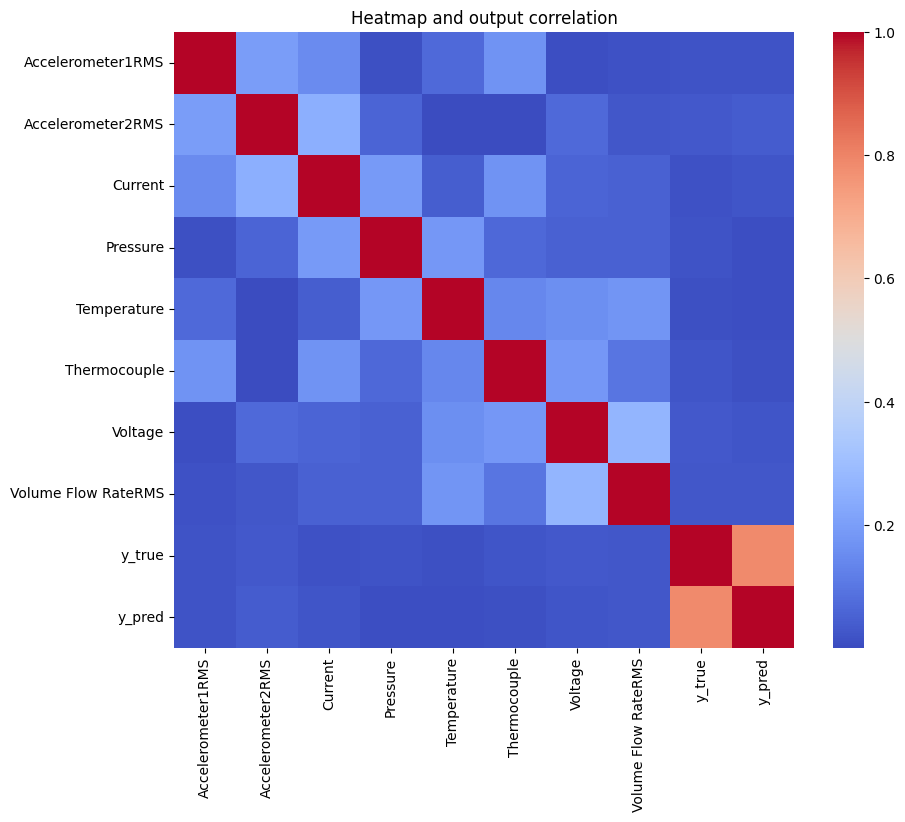

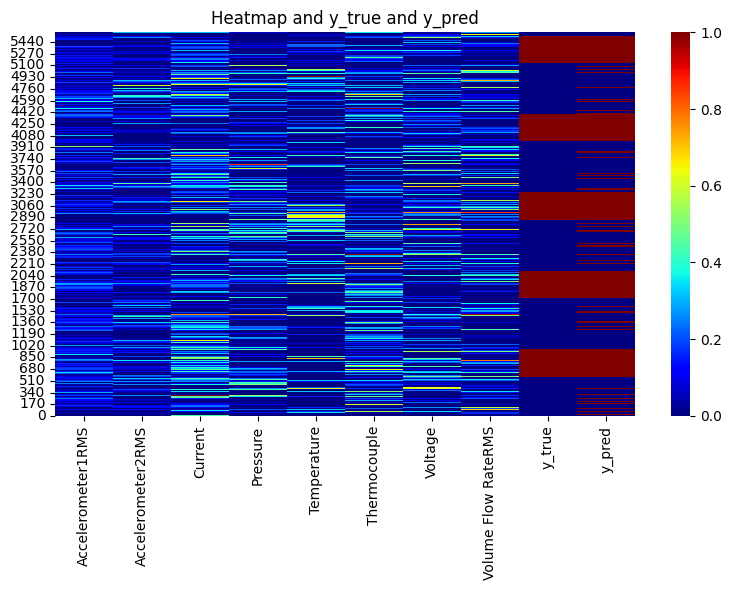

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import os
import seaborn as sns

def show_timeseries(ts, heatmap, y_true, y_pred, channel_dir, cmap='jet', linewidth=3, linestyle='solid', **kwargs):
    """
    Function to plot the time series, with one plot showing the time series without the heatmap
    and another showing it with the heatmap.

    Args:
    - ts (numpy.ndarray): Time series data (channels, time_steps).
    - heatmap (numpy.ndarray, optional): Heatmap data to overlay. If None, no heatmap is shown.
    - cmap (str): Color map for heatmap visualization (default is 'jet').
    - linewidth (float): Line width for the time series plot (default is 3).
    - linestyle (str): Line style for the time series plot (default is 'solid').
    """
    time_data = np.linspace(0, ts.shape[1], ts.shape[1])
    if not os.path.exists(channel_dir):
            os.makedirs(channel_dir)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(time_data, y_true, label='y_true', linewidth=linewidth, linestyle=linestyle)

    ax.set_title('Y_TRUE')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(channel_dir, 'Y_true.png'))
    plt.close(fig)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(time_data, y_true, label='y_pred', linewidth=linewidth, linestyle=linestyle)
    ax.set_title('Y_PRED')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(channel_dir, 'Y_pred.png'))
    plt.close(fig)
    feature_names = test_set.col_name
    for channel in range(ts.shape[0]):

        # Plot the time series without the heatmap
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(time_data, ts[channel], label=feature_names[channel], linewidth=linewidth, linestyle=linestyle)
        ax.set_xlim(time_data[0]-5, time_data[-1]+5)
        ax.set_ylim(ts[channel].min() - 0.1, ts[channel].max() + 0.1)
        ax.set_title(f'Time Series Without Heatmap - Channel {channel}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()
        plt.tight_layout()

        # Save the plot to the channel directory
        plt.savefig(os.path.join(channel_dir, f'channel_{channel}.png'))
        plt.close(fig)

        # Plot the time series with the heatmap, if provided
        if heatmap is not None:
            fig, ax = plt.subplots(figsize=(10, 4))
            cam_values = heatmap.T  # Transpose heatmap to align with time steps

            # Prepare segments for LineCollection (pairs of consecutive points)
            points = np.array([time_data, ts[channel]]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            # Normalize heatmap values for this channel
            norm = Normalize(vmin=np.min(cam_values[channel]), vmax=np.max(cam_values[channel]))
            lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=linewidth)
            lc.set_array(cam_values[channel])

            ax.add_collection(lc)
            ax.set_xlim(time_data[0]-5, time_data[-1]+5)
            ax.set_ylim(ts[channel].min() - 0.1, ts[channel].max() + 0.1)
            ax.set_title(f'Time Series With Heatmap - Channel {channel}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Value')

            # Add colorbar for the heatmap
            cbar = plt.colorbar(lc, ax=ax, label='Heatmap Value')

            plt.tight_layout()

            # Save the plot to the channel directory
            plt.savefig(os.path.join(channel_dir, f'with_heatmap_channel_{channel}.png'))
            plt.close(fig)

    channels = heatmap.shape[0]

    # Concatenate y_true and y_pred to the heatmap

    extended_heatmap = np.concatenate((heatmap, y_true, y_pred), axis=1)
    num_heatmap_features = heatmap.shape[1]
    columns = list(feature_names) + ['y_true', 'y_pred']
    # Convert to DataFrame
    df = pd.DataFrame(extended_heatmap, columns=columns)

    # Plot the extended heatmap
    if extended_heatmap is not None:
        corr = df.corr().abs()

        plt.figure(figsize=(10, 8))
        plt.title("Heatmap and output correlation")
        sns.heatmap(corr, annot=False, cmap='coolwarm', linecolor='black')
        plt.show()

        plt.figure(figsize=(8, 6))  # adjust size as needed
        sns.heatmap(df, cmap="jet", annot=False)  # annot=True shows values
        plt.gca().invert_yaxis()
        plt.title("Heatmap and y_true and y_pred")
        # Adjust layout and save
        plt.tight_layout()
        plt.savefig(os.path.join(channel_dir, 'HeatMap.png'))
        plt.show()


    return plt

print("f1 score:", f1)

y_true1 = np.array(y_true).reshape(len(y_true), 1)
y_pred1 = np.array(y_pred).reshape(len(y_pred), 1)
ts1 = np.concatenate(ts, axis=1)
heatmaps1 = np.concatenate(heatmaps, axis=0)


# Normalize the heatmaps
if np.isnan(heatmaps1).any():
    # Option 1: Replace NaN with a specific value (e.g., 0)
    heatmaps1 = np.nan_to_num(heatmaps1, nan=0.0)
    print("NaN values replaced with 0.")

norm = Normalize(vmin=np.min(heatmaps1), vmax=np.max(heatmaps1))
heatmaps1 = norm(heatmaps1)


show_timeseries(ts1[: test_set.col_num, :y_true1.shape[0]//2], heatmaps1[:y_true1.shape[0]//2, : test_set.col_num],y_true1[:y_true1.shape[0]//2, :],y_pred1[:y_true1.shape[0]//2, :], output_dir)

